# Hibridna diferenčna shema

Preklapljamo med centralno diferenčno shemo in priveterno shemo glede na vrednost $Pe$.
Diskretizacija se zamenja pri $Pe=2$.
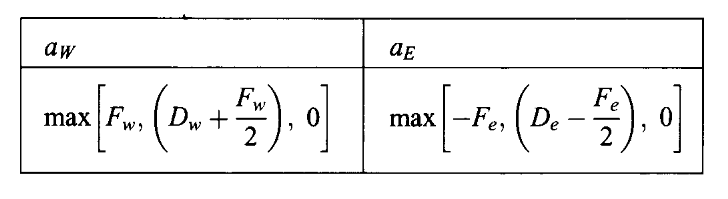

In [4]:
# -*- coding: utf-8 -*-

#advection_first_order_UW, a demonstration of stabilized FVM for transport equation in 1D
#Copyright (C) 2020  Boštjan Mavrič, Matjaž Zadnik
#
#This program is free software: you can redistribute it and/or modify
#it under the terms of the GNU General Public License as published by
#the Free Software Foundation, either version 3 of the License, or
#(at your option) any later version.
#
#This program is distributed in the hope that it will be useful,
#but WITHOUT ANY WARRANTY; without even the implied warranty of
#MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#GNU General Public License for more details.
#
#You should have received a copy of the GNU General Public License
#along with this program.  If not, see <http://www.gnu.org/licenses/>.

from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual


def upwind_advection(N, u):
    # Transport v 1D z advekcijo in difuzijo 

    # Robni pogoji
    fiA=1 # pri x=0
    fiB=0 # pri x=L

    # Snovni parametri
    L=1 # [m] dolžina odseka
    rho=1 # [kg/m^3] gostota transportirane količine
    #=20 # [m/s] hitrost tekočine
    Gama=0.1 # [kg/ms] posplošen koeficient prevodnosti

    # Diskretizacija
    #N=50 # število mrežnih točk
    dx=L/N # [m] krajevni korak

    F=rho*u
    D=Gama/dx
    
    aW=np.max([F,(D + F/2), 0e0])
    aE=np.max([-F,(D - F/2), 0e0])
    # mrežne točke od 2 do N-1
    Pe=F/D
    if (abs(Pe)<2e0):    
        
        aP=aW+aE

        # Matrika sistema brez upoštevanja robnih pogojev
        d=aP*np.ones(N) # diagonala
        s=-aW*np.ones(N-1) # spodnja obdiagonala
        z=-aE*np.ones(N-1) # zgornja obdiagonala

        # vektor vrednosti izvorov
        b=np.zeros(N) 

        # levi rob (točka 1)
        d[0]=(F/2+3*D)
        b[0]=(2*D+F)*fiA
        

        # Desni rob (točka N)

        d[N-1]=3*D-F/2
        b[N-1]=(2*D+F)*fiB

    elif (Pe >= 2e0):
        aP=aW+aE
        # Matrika sistema brez upoštevanja robnih pogojev
        d=aP*np.ones(N) # diagonala
        s=-aW*np.ones(N-1) # spodnja obdiagonala
        z=-aE*np.ones(N-1) # zgornja obdiagonala

        # vektor vrednosti izvorov
        b=np.zeros(N) 

        # levi rob (točka 1)
        d[0]=(F+2*D)
        b[0]=(2*D+F)*fiA

        # Desni rob (točka N)
        d[N-1]=2*D + F
        b[N-1]=(2*D)*fiB
        #b[N-1]=-(F+2*D)*fiB
        
    elif (Pe <= -2e0):
        aP=aW+aE
        # Matrika sistema brez upoštevanja robnih pogojev
        d=aP*np.ones(N) # diagonala
        s=-aW*np.ones(N-1) # spodnja obdiagonala
        z=-aE*np.ones(N-1) # zgornja obdiagonala

        # vektor vrednosti izvorov
        b=np.zeros(N) 

        # levi rob (točka 1)
        d[0]=(-F+2*D)
        b[0]=(2*D)*fiA

        # Desni rob (točka N)
        d[N-1]=-2*D + F
        b[N-1]=(2*D - F)*fiB

    #### rešimo sistem enačb AT=b z algoritmom, ki upošteva tridiagonalno zgradbo matrike A ###
    def TDMAsolver(a, b, c, d):
        '''
        TDMA solver, a b c d can be NumPy array type or Python list type.
        refer to http://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
        and to http://www.cfd-online.com/Wiki/Tridiagonal_matrix_algorithm_-_TDMA_(Thomas_algorithm)
        '''
        nf = len(d) # number of equations
        ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
        for it in range(1, nf):
            mc = ac[it-1]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = bc
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        return xc

    fi=TDMAsolver(s, d, z, b)

    def analiticFi(x):
        'Točna rešitev'
        return fiA+(fiB-fiA)*(np.exp(rho*u*x/Gama)-1)/(np.exp(rho*u*L/Gama)-1)


    # krajevna mreža
    x_tab=np.array([dx*i for i in range(N)])
    x_tab=x_tab+dx/2

    # Graf T profila
    y_values=analiticFi(x_tab)
    eps_rel=np.linalg.norm(y_values-fi)/np.linalg.norm(y_values)
    
    title_string=" Hibridna shema \n Pe=%.2f    Relativna $L_2$ napaka= %.2e" % ( Pe, eps_rel)
    
    plt.plot(x_tab,fi,'bo',label='numerično')
    x_tab1=np.linspace(0,N*dx,1000)
    plt.plot(x_tab1,analiticFi(x_tab1),'b-',label='analitično')
    plt.xlim(0,N*dx)
    plt.xlabel('razdalja $x$ (m)')
    plt.ylabel('$\Phi$ ')   
    plt.legend(loc='best')
    #plt.title('1D profil kolicine $\Phi$') 
    plt.title(title_string) 
    plt.show()

In [5]:
N_slider = widgets.IntSlider(min=5, max=50, step=5, value=5)
u_slider = widgets.FloatSlider(min=-10, max=10, step=0.5, value=2.5)
w=widgets.interactive(upwind_advection,
                      N=N_slider, 
                      u=u_slider
                     )
display(w)

interactive(children=(IntSlider(value=5, description='N', max=50, min=5, step=5), FloatSlider(value=2.5, descr…